In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
degenerate_symbols = {
    'A' : ['A'],
    'C' : ['C'],
    'G' : ['G'],
    'T' : ['T'],
#    'U' : ['U'],
    'W' : ['A', 'T'],
    'S' : ['C', 'G'],
    'M' : ['A', 'C'],
    'K' : ['G', 'T'],
    'R' : ['A', 'G'],
    'Y' : ['C', 'T'],
    'B' : ['C', 'G', 'T'],
    'D' : ['A', 'G', 'T'],
    'H' : ['A', 'C', 'T'],
    'V' : ['A', 'C', 'G'],
    'N' : ['A', 'C', 'G', 'T'],
    'Z' : [],
}


In [3]:
lib_design_strc = [
    'GGAGGRGATGRATRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYATY',
    'GGAAGRGATGRATRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYTTY',
    'GGAGGRGATGRCTRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYAGY',
    'GGAGGRGATGRATRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYATY',
    'GGAAGRGATGRCTRYRYCCGGKHCCRKWWYGGCDTGHGGRGYRYTGY',
    'GGAAGRGATGRATRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYTTY',
    'GGAGGRGATGRCTRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYAGY',
    'GGAAGRGATGRCTRYRYCCGGKHCCYKWWRGGCDTGHGGRGYRYTGY'
]

In [4]:
def getFrequencies(sequences, counts=None, alphabet=['A', 'T', 'G', 'C']):

    """
    Computes the frequency of each base from the defined alphabet at each position in a list of equal-length DNA sequences.
    
    Args:
        sequences (list of str): List of DNA sequences (all must be the same length).
        counts (list of ints): List of integers indicating the count of each unique sequence.
    
    Returns:
        pd.DataFrame: A DataFrame where columns are bases (A, C, G, T) and rows are positions (0-indexed).
    """
    
    seqlen = len(sequences[0])
    dct_counts = {char : [0 for i in range(0, seqlen)] for char in alphabet}

    if counts is None:
        counts = [1 for x in range(0, len(sequences))]    

    for c, s in zip(counts, sequences):
        for i in range(0, seqlen):
            dct_counts[s[i]][i] += c
            
    df_counts = pd.DataFrame(dct_counts)
    df_frequencies = df_counts/sum(counts)
    return df_frequencies

In [5]:
def getExpected(F, s):
    """
    Computes the probability of a sequence s given the initial model - frequency matrix F

    Args:
        s (str): a single sequence
        F (dct): A dictionary of frequencies

    """
    return np.prod(np.array([F[s[i]][i] for i in range(0, len(s))]))

In [6]:
def get_sublibrary_members(sublibrary):
    sublib_undegenerated = [degenerate_symbols[c] for c in sublibrary]
    return [''.join(x) for x in list(product(*sublib_undegenerated))]

In [7]:
def generate_library(lib_design):
    library = []
    for i in range(0, len(lib_design)):
        library.extend(get_sublibrary_members(lib_design[i]))
    return library

In [8]:
df_strc_init = pd.read_csv('../../datasets/datasets_prepped/strc_init.csv', index_col=0)

In [9]:
number_of_mols_synthesized = 5.6*10**13

In [10]:
df_snfq = getFrequencies(df_strc_init['seq'], counts=df_strc_init['count'])
dct_snfq = df_snfq.to_dict()

In [11]:
# Generate all library members from the library design
encoded_lib_members = generate_library(lib_design_strc)

# For each theoretical library member, compute the expected frequency
expected_frequencies = np.array([getExpected(dct_snfq, s) for s in encoded_lib_members])

# Multiply these frequencies by the number of synthesized molecules to get the copy number distribution
copy_numbers = expected_frequencies * number_of_mols_synthesized

# Sort copy numbers
copy_numbers = np.sort(copy_numbers)

Here is what the distribution looks like when I compute the copy numbers for all sequences encoded by the library.

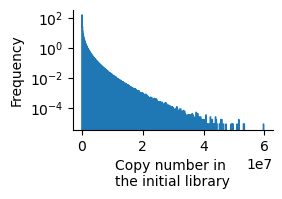

In [12]:
# Plot the distribution of copy numbers with the 99th percentile represented by a vertical line
axis_width, axis_height = 2, 1.2
left_margin, bottom_margin = 1, 1
fig_width = left_margin + axis_width + 0.5
fig_height = bottom_margin + axis_height + 0.5
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_axes([left_margin / fig_width, bottom_margin / fig_height, axis_width / fig_width, axis_height / fig_height])

# Plot
sns.histplot(copy_numbers, bins=500, element='step', stat='frequency', alpha=1)

plt.yscale('log')
plt.xlabel('Copy number in \nthe initial library')
sns.despine()

plt.show()
#plt.savefig('cpm_distribution_initial_expected.pdf')
#plt.savefig('cpm_distribution_initial_expected.svg')

Here are the nubmers:

In [45]:
# Get the min and max copy number if we consider the entire encoded sequence space
min_copy_number = copy_numbers.min()
max_copy_number = copy_numbers.max()

print(f'copy number min: {min_copy_number}')
print(f'copy number max: {max_copy_number}')
print(f'fold difference between most and least abundant:{max_copy_number / min_copy_number}')

copy number min: 40.68598956759139
copy number max: 59757822.8939288
fold difference between most and least abundant:1468756.7766946773


Here is what it looks like when I drop various percentages of sequences from the right tail of the distributions.

In [46]:
thresholds = list(range(1, 51))

res = []

for i in range(0, len(thresholds)):
    x_perc = int((len(copy_numbers) / 100) * thresholds[i])
    copy_numbers_sub = copy_numbers[:-x_perc]
    res.append([thresholds[i], copy_numbers_sub.min(), copy_numbers_sub.max()])

df_res = pd.DataFrame(res, columns=['percent_shaved', 'min', 'max'])
df_res['range'] = df_res['max'] / df_res['min']

df_res

,percent_shaved,min,max,range
0,1,40.68599,5.104712e+06,125466.089680
1,2,40.68599,3.551710e+06,87295.659431
2,3,40.68599,2.766080e+06,67986.048584
3,4,40.68599,2.264815e+06,55665.729195
4,5,40.68599,1.909333e+06,46928.523935
5,6,40.68599,1.640716e+06,40326.323419
6,7,40.68599,1.429369e+06,35131.725679
7,8,40.68599,1.258000e+06,30919.738765
8,9,40.68599,1.116176e+06,27433.919399
9,10,40.68599,9.967275e+05,24498.051867


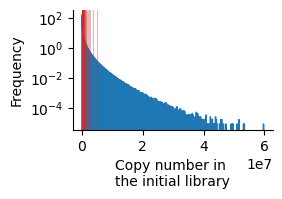

In [47]:
# Plot the distribution of copy numbers with the 99th percentile represented by a vertical line
axis_width, axis_height = 2, 1.2
left_margin, bottom_margin = 1, 1
fig_width = left_margin + axis_width + 0.5
fig_height = bottom_margin + axis_height + 0.5
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_axes([left_margin / fig_width, bottom_margin / fig_height, axis_width / fig_width, axis_height / fig_height])

# Plot
sns.histplot(copy_numbers, bins=500, element='step', stat='frequency', alpha=1)

for index, row in df_res.iterrows():
    plt.axvline(row['max'], color='tab:red', alpha=0.5, linewidth=0.5)
    
plt.yscale('log')
plt.xlabel('Copy number in \nthe initial library')
sns.despine()

plt.show()